In [1]:
# using examples/cosmicshear to check theory data vectors from firecrown (binning etc)
# accessing firecrown stuff from likelihood object is from des3x2/..PT example
# modeling tools returned in addition to likelihood?

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sacc
import pyccl as ccl

In [5]:
import firecrown.likelihood.gauss_family.statistic.source.weak_lensing as wl
import firecrown.likelihood.gauss_family.statistic.source.number_counts as nc
from firecrown.likelihood.gauss_family.statistic.two_point import TwoPoint
from firecrown.likelihood.gauss_family.gaussian import ConstGaussian
from firecrown.modeling_tools import ModelingTools
from firecrown.parameters import ParamsMap

ModuleNotFoundError: No module named 'firecrown'

In [5]:
#firecrown_shear_dir = '/Users/heatherp/Documents/DESC_SRD/forecasting/firecrown/examples/cosmicshear'

In [6]:
h=0.6727
cosmo_fid_srd = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

cosmo_fid_srd.compute_nonlin_power()

In [7]:
systematics_params = ParamsMap(
        {
            "lens0_bias": 1.562362,
            "lens1_bias": 1.732963,
            "lens2_bias": 1.913252,
            "lens3_bias": 2.100644,
            "lens4_bias": 2.293210,
        }
    )

In [8]:
def build_likelihood(_):
    """Create a firecrown likelihood for an SRD-like galaxy clustering analysis.
    No systematics yet apart from linear bias. 
    Based on DES 3x2pt example in firecrown"""
    
    sources: Dict[str, nc.NumberCounts] = {}
        
    for i in range(5):
        sources[f"lens{i}"] = nc.NumberCounts(
            sacc_tracer=f"lens{i}"
        )

    # Now that we have all sources we can instantiate all the two-point
    # functions. For each one we create a new two-point function object.
    stats = {}
    for i in range(5):
        stats[f"ell_cl_lens{i}_lens{i}"] = TwoPoint(
            source0=sources[f"lens{i}"],
            source1=sources[f"lens{i}"],
            sacc_data_type="galaxy_density_cl",
        )

    # Here we instantiate the actual likelihood. The statistics argument carry
    # the order of the data/theory vector.
    modeling_tools = ModelingTools()
    likelihood = ConstGaussian(statistics=list(stats.values()))

    # We load the correct SACC file.
    saccfile = "lsst_y1_desc_srd_sacc.fits"
    sacc_data = sacc.Sacc.load_fits(saccfile)

    likelihood.read(sacc_data)
    
    print(
        "Using parameters:", list(likelihood.required_parameters().get_params_names())
    )

    # This script will be loaded by the appropriated connector. The framework
    # will call the factory function that should return a Likelihood instance.
    return likelihood, modeling_tools


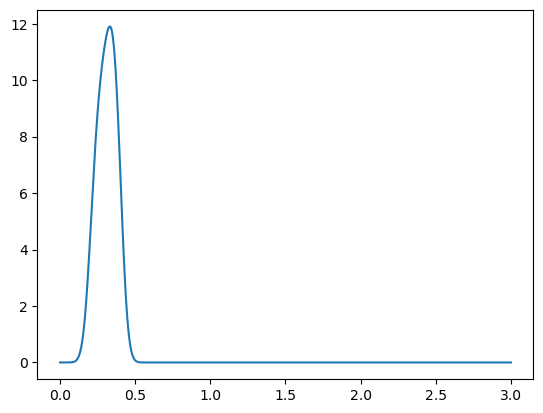

In [7]:
# Load sacc file
saccfile = "lsst_y1_desc_srd_sacc.fits"
sacc_data = sacc.Sacc.load_fits(saccfile)

lens0_tracer = sacc_data.get_tracer("lens0")
lens_z, lens_nz = lens0_tracer.z, lens0_tracer.nz

plt.plot(lens_z, lens_nz)

In [8]:
for n, t in sacc_data.tracers.items():
    print(t.name, t.quantity, type(t))
    
# Type of power spectra
data_types = np.unique([d.data_type for d in sacc_data.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", sacc_data.get_tracer_combinations())

# Data size
print("Size: ", sacc_data.mean.size)

lens0 galaxy_density <class 'sacc.tracers.NZTracer'>
lens1 galaxy_density <class 'sacc.tracers.NZTracer'>
lens2 galaxy_density <class 'sacc.tracers.NZTracer'>
lens3 galaxy_density <class 'sacc.tracers.NZTracer'>
lens4 galaxy_density <class 'sacc.tracers.NZTracer'>
Data types:  ['galaxy_density_cl']
Tracer combinations:  [('lens0', 'lens0'), ('lens1', 'lens1'), ('lens2', 'lens2'), ('lens3', 'lens3'), ('lens4', 'lens4')]
Size:  100


In [9]:
for t in sacc_data.tracers:
    print(t)

lens0
lens1
lens2
lens3
lens4


(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)


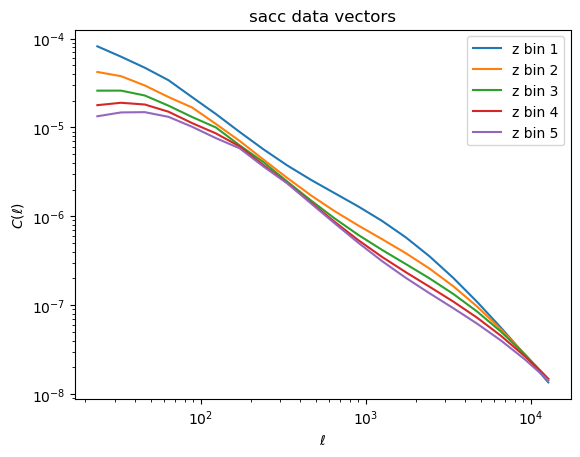

In [11]:
for i in range(5):
    l, cl_gg= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)
    print(l.shape, cl_gg.shape)
    plt.loglog(l, cl_gg, label='z bin %d'%(i+1))
plt.legend()
plt.title("sacc data vectors")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()

In [12]:
likelihood, tools = build_likelihood(None)

# Apply the systematics parameters
likelihood.update(systematics_params)

# Prepare the cosmology object
tools.prepare(cosmo_fid_srd)

# Compute the log-likelihood, using the ccl.Cosmology object as the input
log_like = likelihood.compute_loglike(tools)

print(f"Log-like = {log_like:.1f}")

Using parameters: ['lens2_bias', 'lens4_bias', 'lens1_bias', 'lens3_bias', 'lens0_bias']
Log-like = -7274.6


In [13]:
print(len(likelihood.statistics))

5


[('galaxies', 'galaxies'), 'total']
[('galaxies', 'galaxies'), 'total']
[('galaxies', 'galaxies'), 'total']
[('galaxies', 'galaxies'), 'total']
[('galaxies', 'galaxies'), 'total']


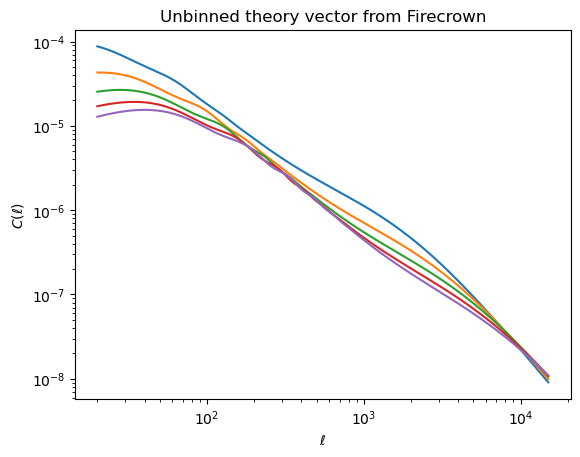

In [14]:
for i in range(5):
    print(list(likelihood.statistics[i].cells.keys()))
    ells = likelihood.statistics[i].ells
    c_ells_gg = likelihood.statistics[i].cells[("galaxies", "galaxies")]
    plt.loglog(ells, c_ells_gg, label='z bin %d'%(i+1))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.title('Unbinned theory vector from Firecrown')
plt.show()

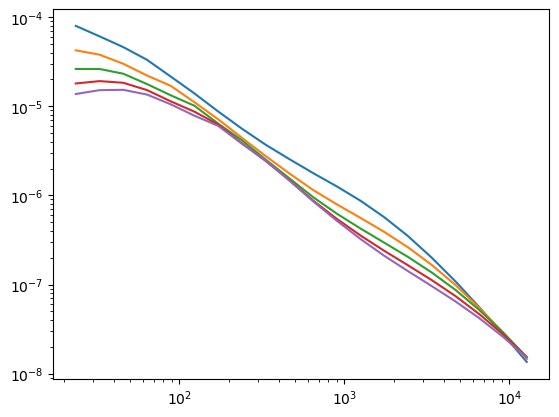

In [15]:
# bin using tophat window function
nbin_ell = 20 
lmin = 20
lmax = 15000
ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]


for i in range(5):
    ells = likelihood.statistics[i].ells
    c_ells_gg = likelihood.statistics[i].cells[("galaxies", "galaxies")]
    cl_binned=[np.mean(c_ells_gg[(ells>=ell_edges[j]) & (ells<=ell_edges[j+1])]) for j in range(nbin_ell)]
    plt.loglog(ell_centers, cl_binned)
    

In [17]:
#compare cosmolike
clike_dir = '/Users/heatherp/Documents/DESC/CosmoLike-DESC_SRD-master/'
lss_y1_cosmolike = np.loadtxt(clike_dir+'datav/pos_pos_Y1_fid')
lss_y1_ell = np.loadtxt(clike_dir+'ell-values')

(100,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)


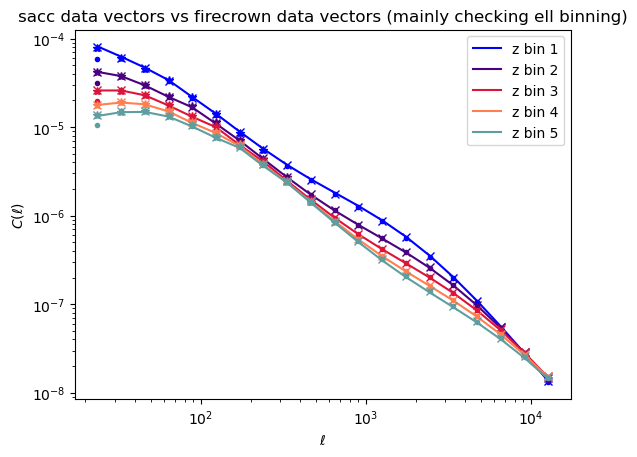

(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)


/var/folders/51/wh4httv54kl_2107dbdnknz40000gq/T/ipykernel_27815/1927125869.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, (th[i*nbinl:(i+1)*nbinl]-lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1])/lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1], '*', color=colors[i], label='z bin %d'%(i+1))


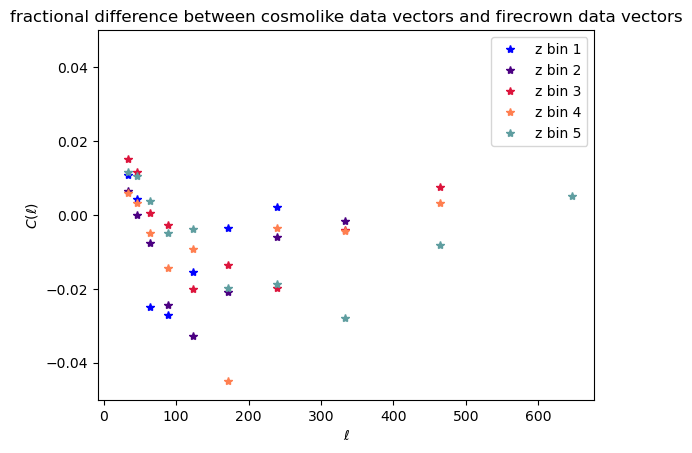

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)
(20,) (20,)


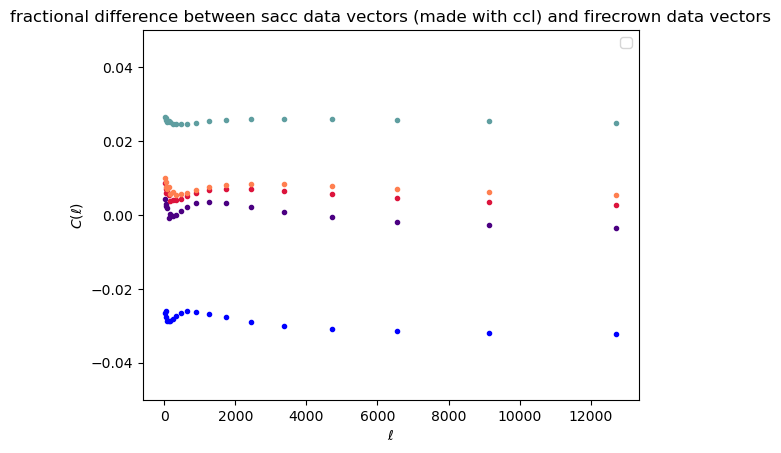

In [18]:
th = likelihood.compute_theory_vector(tools)
print(th.shape)
nbinz=5
nbinl=20
colors=['blue', 'indigo', 'crimson', 'coral', 'cadetblue']
for i in range(nbinz):
    # sacc data vector
    l, cl_gg= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)
    print(l.shape, cl_gg.shape)
    
    # directly binning likelihood's unbinned data vector
    ells = likelihood.statistics[i].ells
    c_ells_gg = likelihood.statistics[i].cells[("galaxies", "galaxies")]
    cl_binned=[np.mean(c_ells_gg[(ells>=ell_edges[j]) & (ells<=ell_edges[j+1])]) for j in range(nbin_ell)]
    
    
    plt.loglog(lss_y1_ell, lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1],  '*', color=colors[i])
    plt.loglog(l, th[i*nbinl:(i+1)*nbinl], '.', color=colors[i])
    plt.loglog(l, cl_binned, 'x', color=colors[i])
    plt.loglog(l, cl_gg, label='z bin %d'%(i+1), color=colors[i])
plt.legend()
plt.title("sacc data vectors vs firecrown data vectors (mainly checking ell binning)")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()

for i in range(nbinz):
    l, cl_gg= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)
    print(l.shape, cl_gg.shape)
    plt.plot(l, (th[i*nbinl:(i+1)*nbinl]-lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1])/lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1], '*', color=colors[i], label='z bin %d'%(i+1))
    #plt.plot(l, (th[i*nbinl:(i+1)*nbinl]-cl_gg)/cl_gg, '.', color=colors[i]) 
plt.legend()
plt.ylim(-0.05, 0.05)
plt.title("fractional difference between cosmolike data vectors and firecrown data vectors")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()

for i in range(nbinz):
    l, cl_gg= sacc_data.get_ell_cl('galaxy_density_cl', 'lens%d'%i, 'lens%d'%i)#, return_cov=True, return_ind=True)
    print(l.shape, cl_gg.shape)
    #plt.plot(l, (th[i*nbinl:(i+1)*nbinl]-lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1])/lss_y1_cosmolike[i*nbinl:(i+1)*nbinl,1], '*', color=colors[i], label='z bin %d'%(i+1))
    plt.plot(l, (th[i*nbinl:(i+1)*nbinl]-cl_gg)/cl_gg, '.', color=colors[i]) 
plt.legend()
plt.ylim(-0.05, 0.05)
plt.title("fractional difference between sacc data vectors (made with ccl) and firecrown data vectors")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.show()